In [3]:
from matplotlib import pyplot as plt
from matplotlib import style
%matplotlib inline
import PythonTools as PT
PT.PlotSettings()
import numpy as np
from timeit import default_timer as timer

In [4]:
import numba
from numba import jit

class Support_Vector_Machine:
    
    def __init__(self,visualization=True, figsize=(5,5)): # initialization method
        self.visualization = visualization
        self.colors={1:'r',-1:'b'}
        if self.visualization:
            self.fig = plt.figure(figsize=figsize)
            self.ax = self.fig.add_subplot(111)
    

    def fit(self, data):
        self.data = data
        # { ||w||: [w,b] }
        opt_dict = {}
        
        transforms = [[1,1],
                      [-1,1],
                      [-1,-1],
                      [1,-1]]
        
        all_data = []
        for yi in self.data:
            for featureset in self.data[yi]:
                for feature in featureset:
                    all_data.append(feature)
                    
        self.max_feature_value = max(all_data)
        self.min_feature_value = min(all_data)
        self.range_feature= max(all_data)-min(all_data)
        all_data = None
        
        # Support vectors yi(xi.w+b) = 1
        # 
        
        step_sizes = [self.range_feature*0.1, # big steps
                      self.range_feature*0.01,
                      self.range_feature*0.001] 
        
        # computationally expensive
        b_range_multiple = 5
        
        # We do not need to take as small steps 
        # with b as we do with w
        b_multiple = 5
        
        latest_optimum = self.max_feature_value * 10
        
        for step in step_sizes:
            w = np.array([latest_optimum,latest_optimum])
            # we can do this because we have a convex problem
            optimized = False
            while not optimized:
                for b in np.arange(-1*(self.max_feature_value*b_range_multiple), 
                                  self.max_feature_value*b_range_multiple, 
                                  step*b_multiple):
                    for tranformation in transforms:
                        w_t = w *  tranformation
                        found_option = True
                        # weakest link in SVM fundumentally
                        # SMO attempts to fix this a bit
                        # yi(xi.w+b) >=1, we are gonna check all data points for this condition
                        for i in self.data:
                            for xi in self.data[i]:
                                yi=i
                                if not yi*(np.dot(w_t,xi)+b) >=1:
                                    found_option = False
                                    break
                            if not found_option:
                                break
                                
                        if found_option:
                            # norm or magniture of w is related to the distance of the
                            # closest point to the hyperplane dist = 2/||w||
                            opt_dict[np.linalg.norm(w_t)] = [w_t,b] 
                            
                if w[0] < 0:
                    optimized = True
                    print('Optimized a step...')
                else:
                    # iterating by step through w and also transform consider possible configurations
                    w = w - step 
                    
            norms = sorted([n for n in opt_dict]) # sort smallest to largest
            opt_choice = opt_dict[norms[0]]
            self.w = opt_choice[0]
            self.b = opt_choice[1]
            # step over w value and the itterate from that until w[0] < 0
            # Note w[0] = w[1], based on how we designed the optimization problem (we want to keep a line with slope of
            # 45 or 135 or -45 or -135)
            latest_optimum = opt_choice[0][0]+step*2 
                        
        print(self.b)                   
                            

    
    def predict(self, features):
        # sign ( x.w + b ): left side or right side of the hyper plane
        classification = np.sign(  np.dot( np.array(features),self.w ) + self.b  )
        
        if (classification!=0) and (self.visualization):
            self.ax.scatter(features[0],features[1], s=200, marker='*', c= self.colors[classification]) 
        return classification
    
    
    
    def visualize(self):
        data_dict=self.data
        [[self.ax.scatter(x[0],x[1],s=100, color=self.colors[i]) for x in data_dict[i]] for i in data_dict]
        
        # hyperplane =x.w+b
        # v = x.w+b
        # psv = 1 positive support vector
        # nsv = -1 negative support vector
        # dec = 0 Point on the hyperplane
        def hyperplane(x,w,b,v):
            return (-w[0]*x-b+v) / w[1]
        
        datarange = (self.min_feature_value*0.9,self.max_feature_value*1.1)
        hyp_x_min=datarange[0]
        hyp_x_max=datarange[1]
        
        # positive support vector 
        # x.w+b=1
        psv1 = hyperplane(hyp_x_min, self.w, self.b,1)
        psv2 = hyperplane(hyp_x_max, self.w, self.b,1)
        self.ax.plot([hyp_x_min, hyp_x_max], [psv1, psv2],lw=3,c='k')
        
        # negative support vector first
        # x.w+b=-1
        nsv1 = hyperplane(hyp_x_min, self.w, self.b,-1)
        nsv2 = hyperplane(hyp_x_max, self.w, self.b,-1)
        self.ax.plot([hyp_x_min, hyp_x_max], [nsv1, nsv2],lw=3,c='k')
        
        # condition surface
        # x.w+b=0
        db1 = hyperplane(hyp_x_min, self.w, self.b,0)
        db2 = hyperplane(hyp_x_max, self.w, self.b,0)
        self.ax.plot([hyp_x_min, hyp_x_max], [db1, db2],lw=3,ls='--',c='gold')
        plt.show()    

In [5]:
data_dict = {-1: np.array([[1,7],
                           [2,8],
                           [3,8]]),
             +1: np.array([[5,1],
                           [6,-1],
                           [7,3]])}

Optimized a step...
Optimized a step...
Optimized a step...
0.140000000002


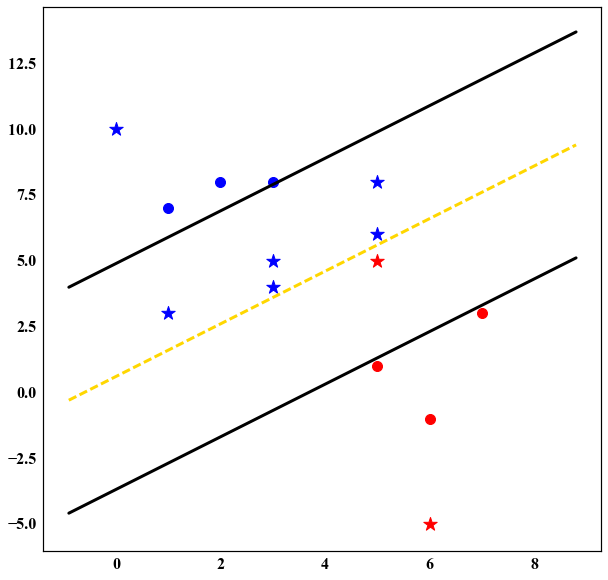

6.8984002677376175


In [6]:
start=timer()
svm = Support_Vector_Machine(figsize=(10,10))
svm.fit(data=data_dict)

predict_us = [[0,10],
              [1,3],
              [3,4],
              [3,5],
              [5,5],
              [5,6],
              [6,-5],
              [5,8]]
for p in predict_us:
    svm.predict(p)
svm.visualize()
print(timer()-start)